# Octave DSP Notebook

This notebook represents the analysis and initial compositional exploration done in order to create a first composition in the style of (or inspired by) the School of Spectralism.

## Sections

The content of this notebook is divided into three sections:

* [Setup](/notebooks/audio-dsp-and-spectralism.ipynb#Setup)
* [Preparation for Composition](/notebooks/audio-dsp-and-spectralism.ipynb#Preparation-for-Composition)
* [Spectralism: Composing in the Spirit of Gérard Grisey](/notebooks/audio-dsp-and-spectralism.ipynb#Spectralism:-Composing-in-the-Spirit-of-G%C3%A9rard-Grisey)

## Setup

In [114]:
% Load the signal processing package
pkg load signal;
pkg load image;

% Set up plotting
graphics_toolkit('gnuplot');

% Pull in custom functions
source('packages/custom-dsp/freq-analysis.m');
source('packages/custom-dsp/time-varying-analysis.m');
source('packages/custom-dsp/spectral-io.m');

printf('\nOctave DSP ready ...\n');

Helper functions loaded with MIDI extensions!
Time-varying analysis functions loaded!
Spectral I/O functions loaded!

Octave DSP ready ...


Note: the above `source` calls include functions specifically written for this exploration and are not part of any official or community Octave package. Their sources are displayed at the bottom of this document.

### Baseline: Sine Tone

Before diving into the spectrum analysis of actual instruments, let's establish a baseline using a sine tone at 440 Hz:

In [2]:
% Generate a pure 440 Hz sine wave
fs = 44100;
duration = 1.0;
t = (0:1/fs:duration-1/fs)';
f0 = 440.0;  % A4

sine = sin(2*pi*f0*t);

printf('Generated 440 Hz sine wave: %d samples\n', length(sine));

Generated 440 Hz sine wave: 44100 samples


In [3]:
% Analyze harmonics
[freqs, amps] = find_harmonics(sine, fs, 8192);
print_harmonics(freqs, amps);

Frequency    Closest    Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Ratio         (dBFS)       (MIDI)             
---------------------------------------------------------------------------
441.4        A4         1.00          -6.4         117        ff      


In [4]:
plot_spectrum(y, fs, 8192, '440 Hz Sine Wave Spectrum');

error: 'y' undefined near line 1, column 15


In [5]:
plot_spectrogram(y, fs, '440 Hz Sine Wave Spectrogram');

error: 'y' undefined near line 1, column 18


## Preparation for Composition

### Physical Instrument Samples

The `.wav` files used below were generated using Spitfire Audio's library "Studio Woodwinds Professional."

#### Clarinet

The following clarinet recording is of E4 with vibrato:

In [6]:
input_file = 'audio/clarinet.wav';
[y, fs] = audioread(input_file);

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n', length(y), fs);

Loaded: 384000 samples at 48000 Hz


In [4]:
% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps] = find_harmonics(y, fs, window_size);
print_harmonics(freqs, amps);

Frequency    Closest    Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Ratio         (dBFS)       (MIDI)             
---------------------------------------------------------------------------
328.1        E4         1.00          -27.6        83         mf      
656.2        E5         2.00          -40.2        59         p       
990.2        B5         3.02          -23.7        90         mf      
1318.4       E6         4.02          -27.8        83         mf      
1529.3       G6         4.66          -64.2        1          pppp    
1646.5       G#6        5.02          -25.8        86         mf      
1734.4       A6         5.29          -64.6        1          pppp    
1857.4       A#6        5.66          -63.1        1          pppp    
1980.5       B6         6.04          -36.4        67         mp      
2308.6       D7         7.04          -42.0        55         p       
2636.7       E7         8.04          -45.3        48         pp      
2

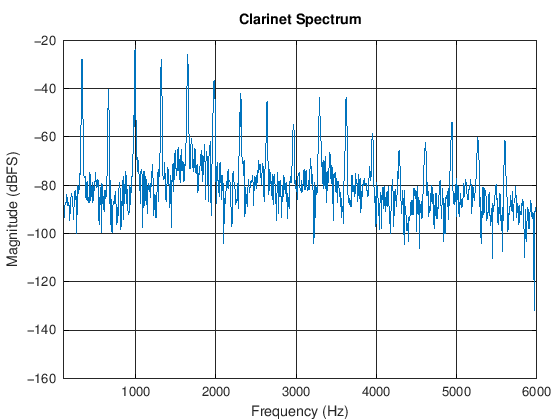

In [8]:
plot_spectrum(y, fs, window_size, 'Clarinet Spectrum');

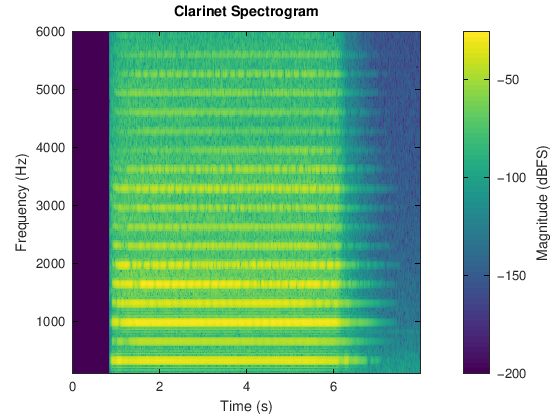

In [9]:
plot_spectrogram(y, fs, 'Clarinet Spectrogram');

Next, let's save our data to a .mat file. We'll be converting this to SDIF, so we need to prepare it with metadata, too.:

In [5]:
meta.fundamental = 328.1;  % E4
meta.sample_rate = fs;
meta.instrument_id = 2;    % 2 = clarinet (see instrument codes below)
meta.midi_note = 52;       % E4 = MIDI note 52
meta.time_stamp = 0.0;

save_static_spectrum('output/clarinet_E4_static.mat', freqs, amps, meta);

Saved static spectrum: output/clarinet_E4_static.mat (20 partials)


Now we're going to do some time-varying analysis.

In [44]:
printf('Analyzing clarinet evolution...\n\n');

window_size = 4096; % we're using a different window siz for time-varying analysis
hop_size = 2048;    % samples between frames
min_amplitude = -60;
[times, freqs_matrix, amps_matrix, meta] = analyze_spectral_evolution(
  input_file, window_size, hop_size, min_amplitude);

Analyzing clarinet evolution...

  Frame 10/186 (t=0.38s)
  Frame 20/186 (t=0.81s)
  Frame 30/186 (t=1.24s)
  Frame 40/186 (t=1.66s)
  Frame 50/186 (t=2.09s)
  Frame 60/186 (t=2.52s)
  Frame 70/186 (t=2.94s)
  Frame 80/186 (t=3.37s)
  Frame 90/186 (t=3.80s)
  Frame 100/186 (t=4.22s)
  Frame 110/186 (t=4.65s)
  Frame 120/186 (t=5.08s)
  Frame 130/186 (t=5.50s)
  Frame 140/186 (t=5.93s)
  Frame 150/186 (t=6.36s)
  Frame 160/186 (t=6.78s)
  Frame 170/186 (t=7.21s)
  Frame 180/186 (t=7.64s)


Partial trajectory plots - show how individual partials evolve over time. Let's look at frequency trajectory first:

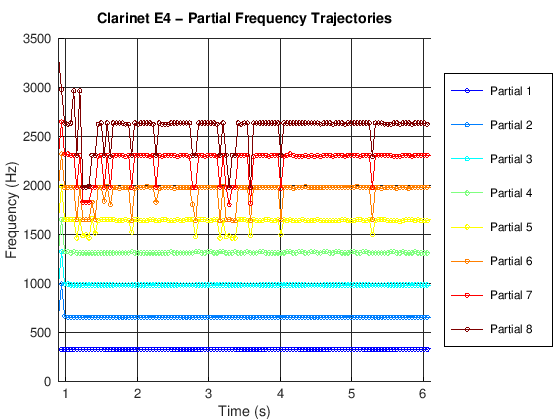

In [106]:
t_range = [0.9,6.1];
plot_partial_freq_trajectories(times, freqs_matrix, 8, 'Clarinet E4', t_range);

Now amplitude:

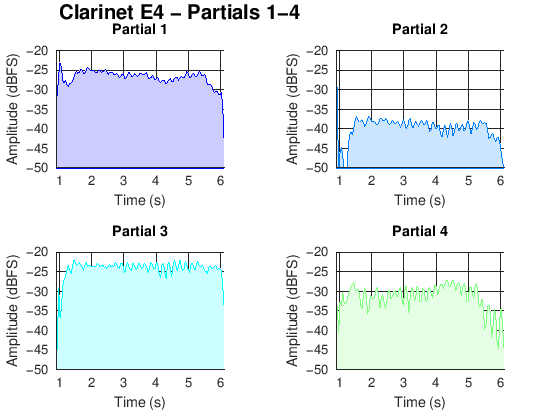

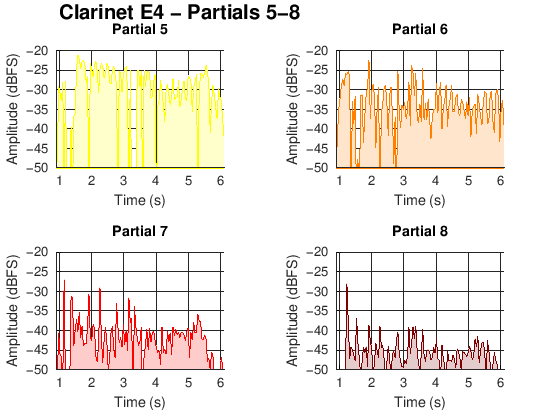

In [122]:
db_range = [-50,-20];
margins = [0.1, 0.1, 0.12, 0.12];
gaps = [0.2, 0.2];
plot_partial_amp_trajectories(times, amps_matrix, 8, 'Clarinet E4', t_range, db_range, margins, gaps);

Harmonic ratio evolution - shows how the harmonic series deviates from perfect integers over time (inharmonicity):

error: 'yline' undefined near line 359, column 9

The 'yline' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.
error: called from
    plot_harmonic_ratios at line 359 column 9


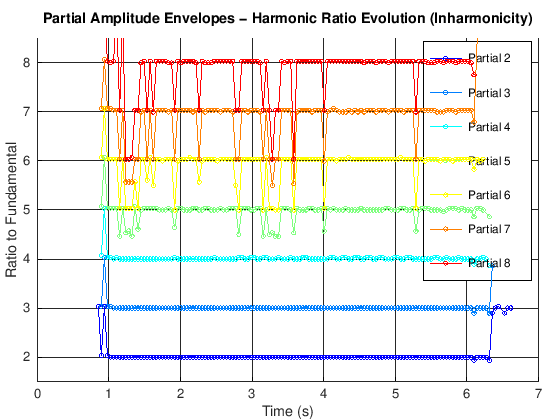

In [48]:
% Plot individual partial trajectories
plot_harmonic_ratios(times, freqs_matrix, 8, 'Partial Amplitude Envelopes');

Spectral centroid over time - Shows the "brightness" evolution, when the sound gets brighter (more high partials) or darker (more fundamental):

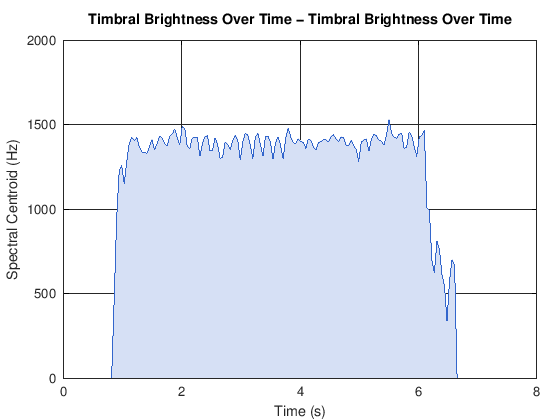

In [34]:
% Calculate spectral centroid for each frame
plot_spectral_centroid(times, freqs_matrix, amps_matrix, 'Timbral Brightness Over Time');

Number of active partials over time - shows when the timbre is richest:

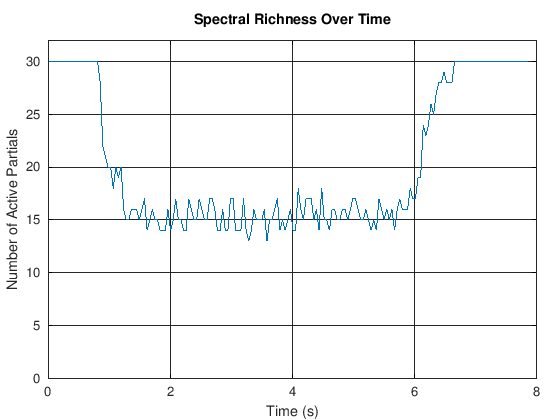

In [40]:
% Count active partials per frame
active_partials = sum(amps_matrix > -10, 2);  % Partials above threshold

figure;
plot(times, active_partials, 'LineWidth', 2);
xlabel('Time (s)');
ylabel('Number of Active Partials');
title('Spectral Richness Over Time');
grid on;
ylim([0 max(active_partials) + 2]);

Finally, let's save this data to a .mat file as well:

In [ ]:
meta.fundamental = 328.1; % E4
meta.instrument_id = 2;   % 2 = clarinet (see instrument codes below)
meta.midi_note = 52;      % E4

save_spectral_evolution('output/clarinet_E4_evolution.mat', times, freqs_matrix, amps_matrix, meta);

#### Oboe

The following oboe recording is of A4 with vibrato:

In [10]:
[y, fs] = audioread('audio/oboe.wav');

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n\n', length(y), fs);

% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps] = find_harmonics(y, fs, window_size);
print_harmonics(freqs, amps);

Loaded: 384000 samples at 48000 Hz

Frequency    Closest    Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Ratio         (dBFS)       (MIDI)             
---------------------------------------------------------------------------
439.5        A4         1.00          -39.2        61         p       
884.8        A5         2.01          -32.8        73         mp      
1324.2       E6         3.01          -20.6        95         mf      
1757.8       A6         4.00          -39.3        61         p       
2197.3       C#7        5.00          -41.4        56         p       
2648.4       E7         6.03          -49.4        39         pp      
3076.2       G7         7.00          -44.7        49         pp      
3521.5       A7         8.01          -46.5        45         pp      
3955.1       B7         9.00          -48.1        42         pp      
4388.7       C#8        9.99          -54.8        24         ppp     


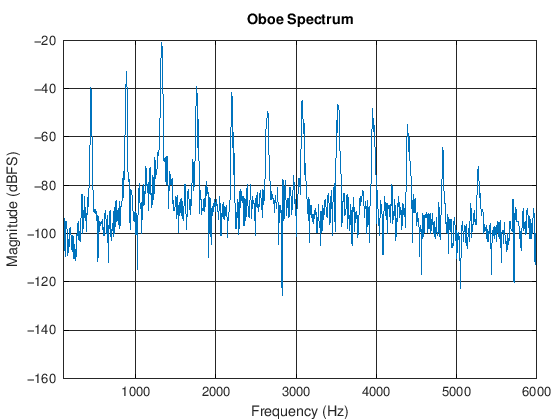

In [11]:
plot_spectrum(y, fs, 8192, 'Oboe Spectrum');

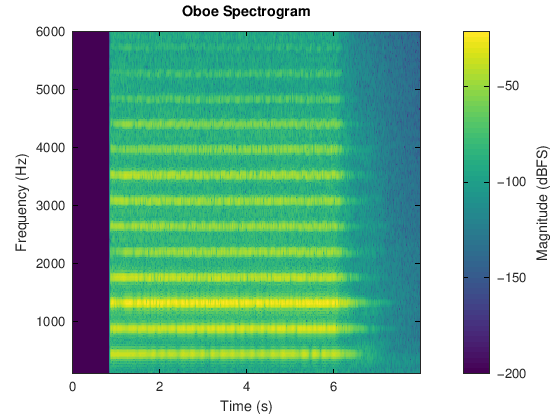

In [12]:
plot_spectrogram(y, fs, 'Oboe Spectrogram');

#### Oboe and Clarinet Together

Just for curiousity, let's look at the two instruments being played together. While these are two samples and as such there will be no resonance interaction between the two, room reverb has been added, so there will be a _little_ acoustic interaction.

In [17]:
[y, fs] = audioread('audio/together.wav');

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n\n', length(y), fs);

% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps] = find_harmonics(y, fs, window_size);
print_harmonics(freqs, amps);

Loaded: 384000 samples at 48000 Hz

Frequency    Closest    Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Ratio         (dBFS)       (MIDI)             
---------------------------------------------------------------------------
328.1        E4         1.00          -29.1        80         mp      
439.5        A4         1.34          -33.3        73         mp      
662.1        E5         2.02          -60.2        1          pppp    
878.9        A5         2.68          -28.1        82         mf      
990.2        B5         3.02          -26.0        86         mf      
1318.4       E6         4.02          -22.6        92         mf      
1646.5       G#6        5.02          -36.3        67         mp      
1757.8       A6         5.36          -36.3        67         mp      
1974.6       B6         6.02          -33.5        72         mp      
2197.3       C#7        6.70          -47.1        44         pp      
2302.7       D7         7.02        

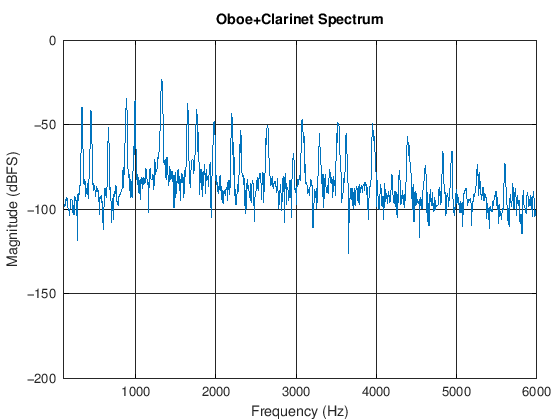

In [14]:
plot_spectrum(y, fs, 8192, 'Oboe+Clarinet Spectrum');

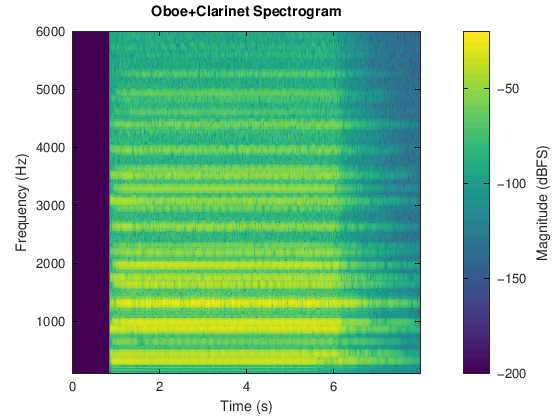

In [18]:
plot_spectrogram(y, fs, 'Oboe+Clarinet Spectrogram');

## Spectralism: Composing in the Spirit of Gérard Grisey

For the source material, I will be using two voices (alto and soprano) from Giovanni Pierluigi da Palestrina's *Missa Papae Marcelli*, in particular a portion of the "Kyrie":

![Score excerpt](./images/palestrina-mpm-kyrie-excerpt.jpg)

I will be recording the sounds of several instruments playing various notes from this harmonic/melodic (voice-leading) content and performing spectral analysis on the partials for said instruments, and then using notes cloest to observed partials to reimagine the harmony and voice-leading.

Taking inspiration from the piece "Partiels" I am going to start the composition with a descent (instead of ascent) down the overtones until we get to the source A and E notes. I will be using the frequencies listed above, filtering out the ones that are possibly noise (non-fundamentals) and subsituting rests for fundamentals that are below a certain threshold. This will give me the following:

Clarinet:

```
Frequency    Closest    Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Ratio         (dBFS)       (MIDI)             
---------------------------------------------------------------------------
328.1        E4         1.00          -27.6        83         mf      
656.2        E5         2.00          -40.2        59         p       
990.2        B5         3.02          -23.7        90         mf      
1318.4       E6         4.02          -27.8        83         mf      
1529.3       G6         4.66          -64.2        1          pppp    
1646.5       G#6        5.02          -25.8        86         mf      
1734.4       A6         5.29          -64.6        1          pppp    
1857.4       A#6        5.66          -63.1        1          pppp    
1980.5       B6         6.04          -36.4        67         mp      
2308.6       D7         7.04          -42.0        55         p       
2636.7       E7         8.04          -45.3        48         pp      
2970.7       F#7        9.05          -54.9        23         ppp     
3293.0       G#7        10.04         -43.5        52         p       
3627.0       A#7        11.05         -43.5        52         p       
3949.2       B7         12.04         -58.3        12         pppp    
4289.1       <rest>     13.07         -65.6        1          pppp    
4611.3       <rest>     14.05         -62.1        1          pppp    
4945.3       D#8        15.07         -53.9        26         ppp     
5267.6       <rest>     16.05         -60.3        1          pppp    
5601.6       <rest>     17.07         -61.4        1          pppp    
```

Oboe:

```
Frequency    Closest    Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Ratio         (dBFS)       (MIDI)             
---------------------------------------------------------------------------
439.5        A4         1.00          -39.2        61         p       
884.8        A5         2.01          -32.8        73         mp      
1324.2       E6         3.01          -20.6        95         mf      
1757.8       A6         4.00          -39.3        61         p       
2197.3       C#7        5.00          -41.4        56         p       
2648.4       E7         6.03          -49.4        39         pp      
3076.2       G7         7.00          -44.7        49         pp      
3521.5       A7         8.01          -46.5        45         pp      
3955.1       B7         9.00          -48.1        42         pp      
4388.7       C#8        9.99          -54.8        24         ppp  
```

For the next phase, I will be using a recording of X at note Y.

For the section after that, I will be using a recording of X at note Y.

## Appendices

### MAT File Metadata

The tool we're using to convert .mat files to .sdif files currently only supports integers and arrays of integers. As such, we've had to encode non-integer metadata as integers. Here's the instrument lookup we've defined for this work:

```
% Instrument codes (for metadata.instrument_id):
% 0 = unspecified/unknown
% 1 = oboe
% 2 = clarinet
% 3 = flute
% 4 = piccolo
% 5 = violin
% 6 = viola
% 7 = cello
% 8 = synthesizer
```

### Helper Functions

Here are the custom functions mentioned and included above that were created specifically for this project:

In [16]:
!cat packages/custom-dsp/freq-analysis.m

% Find harmonics from a spectrum
function [peak_freqs, peak_amps] = find_harmonics(signal, fs, window_size)
    if nargin < 3
        window_size = 4096;
    end

    % Take a chunk from the middle of the file (avoid silence at start/end)
    mid_point = floor(length(signal) / 2);
    start_idx = mid_point - floor(window_size / 2);
    if start_idx < 1
        start_idx = 1;
    end
    chunk_size = min(window_size, length(signal) - start_idx + 1);
    chunk = signal(start_idx:start_idx + chunk_size - 1) .* hanning(chunk_size);

    % Zero-pad for better frequency resolution
    padded = [chunk; zeros(window_size - chunk_size, 1)];

    % Compute spectrum with proper dBFS scaling
    spectrum = abs(fft(padded));
    spectrum = spectrum / (window_size / 2);  % Normalize by FFT size
    spectrum_db = 20 * log10(spectrum(1:window_size/2) + 1e-10);

    % Shift spectrum to be positive for findpeaks
    min_db = min(spectrum_db);
    spectrum_shifted = spectrum_db - min_db;

    % Frequency